In [40]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from sklearn import metrics
import numpy as np
import os
import random
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
!unzip '/content/drive/MyDrive/Диплом данные/UCF_and_Shanghai.zip'

Archive:  /content/drive/MyDrive/Диплом данные/UCF_and_Shanghai.zip
replace UCF-Crime/frames.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Dataset

In [42]:
class Normal_Loader(Dataset):
    """
    is_train = 1 <- train, 0 <- test
    """
    def __init__(self, is_train=1, path='/content/UCF-Crime/'):
        super(Normal_Loader, self).__init__()
        self.is_train = is_train
        self.path = path
        if self.is_train == 1:
            data_list = os.path.join(path, 'train_normal.txt')
            with open(data_list, 'r') as f:
                self.data_list = f.readlines()
        else:
            data_list = os.path.join(path, 'test_normalv2.txt')
            with open(data_list, 'r') as f:
                self.data_list = f.readlines()
            random.shuffle(self.data_list)
            self.data_list = self.data_list[:-10]
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        if self.is_train == 1:
            rgb_npy = np.load(os.path.join(self.path+'all_rgbs', self.data_list[idx][:-1]+'.npy'))
            flow_npy = np.load(os.path.join(self.path+'all_flows', self.data_list[idx][:-1]+'.npy'))
            concat_npy = np.concatenate([rgb_npy, flow_npy], axis=1)
            return concat_npy
        else:
            name, frames, gts = self.data_list[idx].split(' ')[0], int(self.data_list[idx].split(' ')[1]), int(self.data_list[idx].split(' ')[2][:-1])
            rgb_npy = np.load(os.path.join(self.path+'all_rgbs', name + '.npy'))
            flow_npy = np.load(os.path.join(self.path+'all_flows', name + '.npy'))
            concat_npy = np.concatenate([rgb_npy, flow_npy], axis=1)
            return concat_npy, gts, frames

class Anomaly_Loader(Dataset):
    """
    is_train = 1 <- train, 0 <- test
    """
    def __init__(self, is_train=1, path='/content/UCF-Crime/'):
        super(Anomaly_Loader, self).__init__()
        self.is_train = is_train
        self.path = path
        if self.is_train == 1:
            data_list = os.path.join(path, 'train_anomaly.txt')
            with open(data_list, 'r') as f:
                self.data_list = f.readlines()
        else:
            data_list = os.path.join(path, 'test_anomalyv2.txt')
            with open(data_list, 'r') as f:
                self.data_list = f.readlines()

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        if self.is_train == 1:
            rgb_npy = np.load(os.path.join(self.path+'all_rgbs', self.data_list[idx][:-1]+'.npy'))
            flow_npy = np.load(os.path.join(self.path+'all_flows', self.data_list[idx][:-1]+'.npy'))
            concat_npy = np.concatenate([rgb_npy, flow_npy], axis=1)
            return concat_npy
        else:
            name, frames, gts = self.data_list[idx].split('|')[0], int(self.data_list[idx].split('|')[1]), self.data_list[idx].split('|')[2][1:-2].split(',')
            gts = [int(i) for i in gts]
            rgb_npy = np.load(os.path.join(self.path+'all_rgbs', name + '.npy'))
            flow_npy = np.load(os.path.join(self.path+'all_flows', name + '.npy'))
            concat_npy = np.concatenate([rgb_npy, flow_npy], axis=1)
            return concat_npy, gts, frames

# Learner

In [43]:
class Learner(nn.Module):
    def __init__(self, input_dim=2048, drop_p=0.0):
        super(Learner, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self.drop_p = 0.6
        self.weight_init()
        self.vars = nn.ParameterList()

        for i, param in enumerate(self.classifier.parameters()):
            self.vars.append(param)

    def weight_init(self):
        for layer in self.classifier:
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x, vars=None):
        if vars is None:
            vars = self.vars
        x = F.linear(x, vars[0], vars[1])
        x = F.relu(x)
        x = F.dropout(x, self.drop_p, training=self.training)
        x = F.linear(x, vars[2], vars[3])
        x = F.dropout(x, self.drop_p, training=self.training)
        x = F.linear(x, vars[4], vars[5])
        return torch.sigmoid(x)

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars

# Main

# Loss

In [44]:
import torch
import torch.nn.functional as F

def MIL(y_pred, batch_size, is_transformer=0):
    loss = torch.tensor(0.).cuda()
    loss_intra = torch.tensor(0.).cuda()
    sparsity = torch.tensor(0.).cuda()
    smooth = torch.tensor(0.).cuda()
    if is_transformer==0:
        y_pred = y_pred.view(batch_size, -1)
    else:
        y_pred = torch.sigmoid(y_pred)

    for i in range(batch_size):
        anomaly_index = torch.randperm(30).cuda()
        normal_index = torch.randperm(30).cuda()

        y_anomaly = y_pred[i, :32][anomaly_index]
        y_normal  = y_pred[i, 32:][normal_index]

        y_anomaly_max = torch.max(y_anomaly) # anomaly
        y_anomaly_min = torch.min(y_anomaly)

        y_normal_max = torch.max(y_normal) # normal
        y_normal_min = torch.min(y_normal)

        loss += F.relu(1.-y_anomaly_max+y_normal_max)

        sparsity += torch.sum(y_anomaly)*0.00008
        smooth += torch.sum((y_pred[i,:31] - y_pred[i,1:32])**2)*0.00008
    loss = (loss+sparsity+smooth)/batch_size

    return loss

In [67]:
def train(model, optimizer, scheduler, criterion, normal_train_loader, anomaly_train_loader, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (normal_inputs, anomaly_inputs) in enumerate(zip(normal_train_loader, anomaly_train_loader)):
        inputs = torch.cat([anomaly_inputs, normal_inputs], dim=1)
        batch_size = inputs.shape[0]
        inputs = inputs.view(-1, inputs.size(-1)).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, batch_size)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    return train_loss/len(normal_train_loader)

def test_abnormal(model, anomaly_test_loader, normal_test_loader, epoch):
    model.eval()
    auc = 0
    with torch.no_grad():
        for i, (data, data2) in enumerate(zip(anomaly_test_loader, normal_test_loader)):
            inputs, gts, frames = data
            inputs = inputs.view(-1, inputs.size(-1)).to(torch.device('cuda'))
            score = model(inputs)
            score = score.cpu().detach().numpy()
            score_list = np.zeros(frames[0])
            step = np.round(np.linspace(0, frames[0]//16, 33))

            for j in range(32):
                score_list[int(step[j])*16:(int(step[j+1]))*16] = score[j]

            gt_list = np.zeros(frames[0])
            for k in range(len(gts)//2):
                s = gts[k*2]
                e = min(gts[k*2+1], frames)
                gt_list[s-1:e] = 1

            inputs2, gts2, frames2 = data2
            inputs2 = inputs2.view(-1, inputs2.size(-1)).to(torch.device('cuda'))
            score2 = model(inputs2)
            score2 = score2.cpu().detach().numpy()
            score_list2 = np.zeros(frames2[0])
            step2 = np.round(np.linspace(0, frames2[0]//16, 33))
            for kk in range(32):
                score_list2[int(step2[kk])*16:(int(step2[kk+1]))*16] = score2[kk]
            gt_list2 = np.zeros(frames2[0])
            score_list3 = np.concatenate((score_list, score_list2), axis=0)
            gt_list3 = np.concatenate((gt_list, gt_list2), axis=0)

            fpr, tpr, thresholds = metrics.roc_curve(gt_list3, score_list3, pos_label=1)
            auc += metrics.auc(fpr, tpr)

        return auc/140

def start_train(num_epoch=3):

  normal_train_dataset = Normal_Loader(is_train=1)
  normal_test_dataset = Normal_Loader(is_train=0)

  anomaly_train_dataset = Anomaly_Loader(is_train=1)
  anomaly_test_dataset = Anomaly_Loader(is_train=0)

  normal_train_loader = DataLoader(normal_train_dataset, batch_size=30, shuffle=True)
  normal_test_loader = DataLoader(normal_test_dataset, batch_size=1, shuffle=True)

  anomaly_train_loader = DataLoader(anomaly_train_dataset, batch_size=30, shuffle=True) 
  anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=1, shuffle=True)
  
  model = Learner(input_dim=2048, drop_p=0.0).to(device)
  optimizer = torch.optim.Adagrad(model.parameters(), lr= 0.001, weight_decay=0.0010000000474974513)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50])
  criterion = MIL


  auc_progress = []
  loss_progress = []
  auc_max = 0.
  loss_best = 1e9

  for epoch in range(1, num_epoch + 1):
      cur_loss = train(model, optimizer, scheduler, criterion, normal_train_loader, anomaly_train_loader, epoch)
      curr_auc = test_abnormal(model, anomaly_test_loader, normal_test_loader, epoch)

      if epoch % 10 == 0:
        print(f'Epoch: {epoch}')
        print(f'auc = {curr_auc}')
        print(f'loss = {cur_loss}\n')
    
      auc_progress.append(curr_auc)
      loss_progress.append(cur_loss)
      if auc_max < curr_auc:
        auc_max = curr_auc
        torch.save(model.state_dict(), '/content/drive/MyDrive/Диплом данные/best_auc_model')

      if cur_loss < loss_best:
        loss_best = cur_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Диплом данные/best_loss_model')
        
  print('\n' + '-' * 30)
  print(f'Best auc {auc_max}')
 
  return model, auc_progress, loss_progress

In [69]:
model, auc_progress, loss_progress = start_train(1000)

Epoch: 10
auc = 0.8170598821029443
loss = 0.6011526452170478

Epoch: 20
auc = 0.8308189074475884
loss = 0.47330025059205516

Epoch: 30
auc = 0.8177913022423342
loss = 0.42253714579123036

Epoch: 40
auc = 0.8258782813062784
loss = 0.41917895718857096

Epoch: 50
auc = 0.822086233169918
loss = 0.42031456419715174

Epoch: 60
auc = 0.8378214164543298
loss = 0.4172803075225265

Epoch: 70
auc = 0.8231237067836976
loss = 0.41692629235762135

Epoch: 80
auc = 0.8294431021904843
loss = 0.41774427780398615

Epoch: 90
auc = 0.8299502835723336
loss = 0.41480955371150263

Epoch: 100
auc = 0.8181395970583676
loss = 0.4173896069879885

Epoch: 110
auc = 0.8250547031219325
loss = 0.4155633471630238

Epoch: 120
auc = 0.8173157135046591
loss = 0.42021862113917313

Epoch: 130
auc = 0.8279952561378477
loss = 0.4204832547240787

Epoch: 140
auc = 0.8318275656755793
loss = 0.410927121286039

Epoch: 150
auc = 0.825405330846084
loss = 0.41544346456174497

Epoch: 160
auc = 0.8228616445826943
loss = 0.4154458763422

In [70]:
def plot_graph(x, xname):
  plt.figure(figsize=(16, 10))
  plt.xlabel('Epoch')
  plt.ylabel(xname)
    
  plt.plot(np.arange(1, len(x) + 1), x);
 

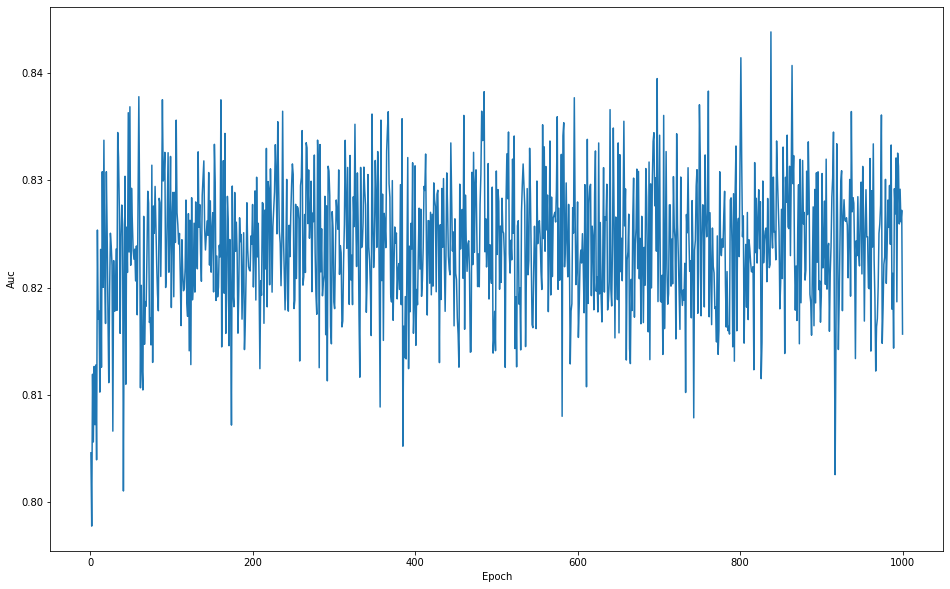

In [71]:
plot_graph(auc_progress, 'Auc')

In [76]:
print(f'best auc {max(auc_progress)}')

best auc 0.8438687642645123


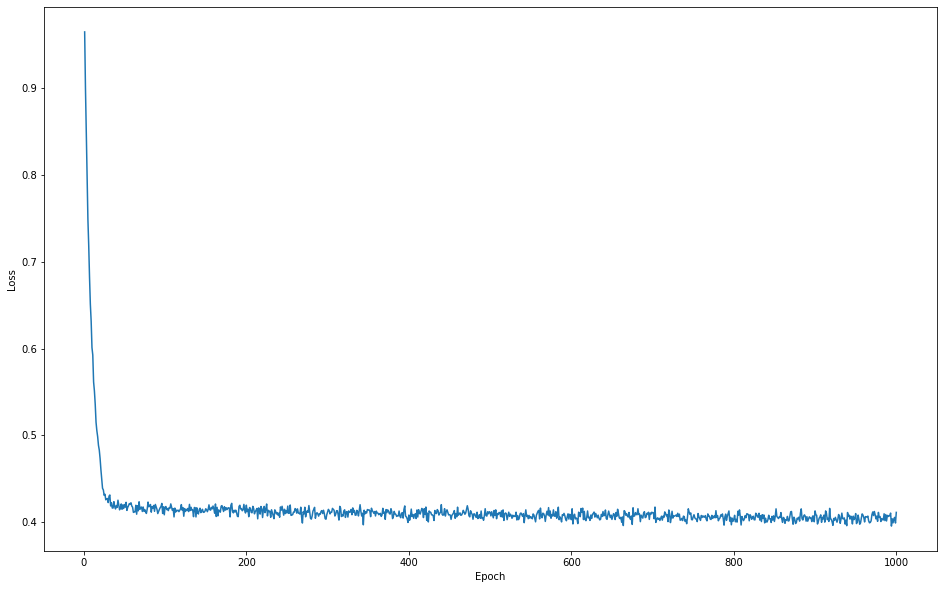

In [72]:
plot_graph(loss_progress, 'Loss')

In [73]:
print(f'best loss {min(loss_progress)}')

best loss 0.395477122730679
